# Evolutionary Strategy for Iterated Prisoner's Dilemma

This notebook showcases a memory-one strategy evolved with CMA-ES
to play the Iterated Prisoner's Dilemma (IPD).

**Unified Parameters**: This demo uses the standardized parameters
from the comparative study: 100 rounds per game, 20 matches per opponent,
and the complete set of 7 opponent strategies.

In [ ]:
import os
import sys
import time
import pickle
import argparse
from pathlib import Path

import cma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Parse command line arguments with unified parameters
parser = argparse.ArgumentParser(description="Demo of Evolutionary Strategy for Iterated Prisoner's Dilemma")
parser.add_argument("--num_rounds", type=int, default=100,
                    help="Number of rounds per episode (unified parameter: 100)")
parser.add_argument("--num_matches", type=int, default=20,
                    help="Number of matches per opponent for evaluation (unified parameter: 20)")
parser.add_argument("--seed", type=int, default=42,
                    help="Random seed (unified parameter: 42)")

# Handle running in Jupyter vs as script
try:
    # When running as a script
    args = parser.parse_args()
except SystemExit:
    # When running in Jupyter (no command line args)
    args = parser.parse_args([])

usage: ipykernel_launcher.py [-h] [--num_rounds NUM_ROUNDS]
                             [--num_matches NUM_MATCHES] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/alex/Library/Jupyter/runtime/kernel-v3097f918100f829acddf82e02a7512c20abd8ed8c.json


In [ ]:
# Detect repository root (works in both .py script and .ipynb)
try:  # running as .py
    repo_root = Path(__file__).resolve().parents[1]
except NameError:  # running inside Jupyter
    repo_root = Path.cwd().resolve()
    if repo_root.name == "notebooks":
        repo_root = repo_root.parent

sys.path.append(str(repo_root))

# Import strategies directly to avoid gymnasium dependency
sys.path.append(str(repo_root / "env"))
from strategies import (
    TitForTat,
    AlwaysCooperate,
    AlwaysDefect,
    RandomStrategy,
    PavlovStrategy,
    GrudgerStrategy,
    GTFTStrategy,
    Strategy,
)

# Import IPDEnv and simulate_match only when needed
def get_ipd_env():
    """Lazy import of IPDEnv to avoid gymnasium dependency during import"""
    from env import IPDEnv, simulate_match
    return IPDEnv, simulate_match

# Paths
models_dir = repo_root / "models"
results_dir = repo_root / "results" / "evolution"
comparison_dir = repo_root / "comparison_results"

# Helper: save plot + CSV so numbers remain accessible
def save_plot_and_csv(x, y, name: str, folder: str = "results"):
    """Save PNG and matching CSV for later analysis."""
    import pandas as pd
    import matplotlib.pyplot as plt

    os.makedirs(folder, exist_ok=True)
    pd.DataFrame({"x": x, "y": y}).to_csv(
        f"{folder}/{name}_data.csv", index=False
    )
    plt.figure()
    plt.plot(x, y)
    plt.title(name.replace("_", " ").title())
    plt.savefig(f"{folder}/{name}.png", dpi=120, bbox_inches="tight")
    plt.close()

## Memory-One Strategy Implementation

A memory-one strategy for the Iterated Prisoner's Dilemma is defined by five probabilities:
1. p_cc: Probability of cooperating if both players cooperated in the previous round
2. p_cd: Probability of cooperating if the player cooperated and opponent defected
3. p_dc: Probability of cooperating if the player defected and opponent cooperated
4. p_dd: Probability of cooperating if both players defected in the previous round
5. initial_action_prob: Probability of cooperating on the first move

In [ ]:
class MemoryOneStrategy(Strategy):
    """Memory-one strategy for IPD."""

    def __init__(self, params, name="MemoryOne"):
        super().__init__(name)
        self.params = np.clip(params, 0.0, 1.0)
        self.p_cc, self.p_cd, self.p_dc, self.p_dd, self.initial_action_prob = self.params
        self.rng = np.random.RandomState()

    def action(self, history, player_idx=0):
        if not history:  # first move
            return 0 if self.rng.random() < self.initial_action_prob else 1

        opp_idx = 1 - player_idx
        last_player, last_opp = history[-1][player_idx], history[-1][opp_idx]

        if last_player == 0 and last_opp == 0:
            prob = self.p_cc
        elif last_player == 0 and last_opp == 1:
            prob = self.p_cd
        elif last_player == 1 and last_opp == 0:
            prob = self.p_dc
        else:
            prob = self.p_dd

        return 0 if self.rng.random() < prob else 1

    def __str__(self):
        return (
            f"{self.name}: "
            f"p_cc={self.p_cc:.2f}, p_cd={self.p_cd:.2f}, "
            f"p_dc={self.p_dc:.2f}, p_dd={self.p_dd:.2f}, init={self.initial_action_prob:.2f}"
        )

## Loading the Evolved Strategy

We load the evolved strategy from the unified training process.
If the model doesn't exist and `QUICK_DEMO=1` is set, we can quickly
evolve a demo strategy for illustration purposes.

In [ ]:
def quick_evolve_strategy(save_dir=models_dir, num_generations=3, population_size=10, seed=args.seed, num_rounds=args.num_rounds, num_matches=3):
    """Quickly evolve a memory-one strategy for demo purposes."""
    print("Quickly evolving a demo strategy...")
    
    # Get IPDEnv with lazy import
    IPDEnv, simulate_match = get_ipd_env()
    
    # Create environment
    env = IPDEnv(num_rounds=num_rounds, seed=seed)
    
    # Complete set of opponent strategies from the comparative study
    opponent_strategies = {
        "TitForTat": TitForTat(),
        "AlwaysCooperate": AlwaysCooperate(),
        "AlwaysDefect": AlwaysDefect(),
        "Random(p=0.5)": RandomStrategy(coop_prob=0.5, seed=seed),
        "Pavlov": PavlovStrategy(),
        "Grudger": GrudgerStrategy(),
        "GTFT(p=0.1)": GTFTStrategy(forgiveness_prob=0.1, seed=seed+100)
    }
    
    # Helper function for fitness evaluation
    def evaluate_fitness(params):
        # Create memory-one strategy from parameters
        strategy = MemoryOneStrategy(params)
        
        total_rewards = []
        
        # Play against each opponent
        for opponent in opponent_strategies.values():
            # Simulate match against opponent
            for _ in range(num_matches):  # Quick matches for demo
                results = simulate_match(env, strategy, opponent, num_rounds=num_rounds)
                total_rewards.append(results['player_score'])
        
        # Return average reward (higher is better)
        return np.mean(total_rewards)
    
    # Initial guess for parameters (a simple cooperative strategy)
    initial_params = np.array([0.9, 0.1, 0.9, 0.1, 0.9])
    
    # Setup CMA-ES optimizer
    es = cma.CMAEvolutionStrategy(
        initial_params,
        0.5,
        {'popsize': population_size, 'seed': seed}
    )
    
    # Run quick evolution
    start_time = time.time()
    
    for generation in range(num_generations):
        solutions = es.ask()
        fitness_values = [evaluate_fitness(sol) for sol in solutions]
        es.tell(solutions, [-fit for fit in fitness_values])  # CMA-ES minimizes
        
        best_fitness = max(fitness_values)
        print(f"Generation {generation+1}: Best fitness = {best_fitness:.2f}")
    
    # Get best solution
    best_params = es.result.xbest
    evolved_strategy = MemoryOneStrategy(best_params, name="QuickEvolved")
    
    print(f"Quick evolution completed in {time.time() - start_time:.1f}s")
    print(f"Evolved strategy: {evolved_strategy}")
    
    # Save the strategy
    os.makedirs(save_dir, exist_ok=True)
    strategy_path = save_dir / "evolved_strategy_quick_demo.pkl"
    with open(strategy_path, 'wb') as f:
        pickle.dump(evolved_strategy, f)
    
    return evolved_strategy, strategy_path

# Try to load the unified evolved strategy
strategy_path = models_dir / "evolved_strategy.pkl"
quick_demo = False

if not strategy_path.exists():
    # Try alternative paths
    alternatives = list(models_dir.glob("evolved_strategy*.pkl"))
    
    if alternatives:
        strategy_path = alternatives[0]
        print(f"Using alternative strategy: {strategy_path.name}")
    elif os.environ.get("QUICK_DEMO") == "1":
        quick_demo = True
        evolved_strategy, strategy_path = quick_evolve_strategy()
    else:
        raise FileNotFoundError(
            "No evolved strategy found. Run 'python agents/evolution/train_evolution.py' or set QUICK_DEMO=1."
        )

if not quick_demo:
    print(f"Loading evolved strategy from {strategy_path.name}")
    with open(strategy_path, 'rb') as f:
        loaded_data = pickle.load(f)
    
    # Handle both old format (dict) and new format (strategy object)
    if isinstance(loaded_data, dict):
        # Old format - create strategy from parameters
        if 'best_params' in loaded_data:
            evolved_strategy = MemoryOneStrategy(loaded_data['best_params'], name="Evolved")
            print(f"Loaded from old format (dict)")
        else:
            raise ValueError("Invalid dictionary format - missing 'best_params'")
    else:
        # New format - direct strategy object
        evolved_strategy = loaded_data
        print(f"Loaded from new format (strategy object)")

print(f"Loaded strategy: {evolved_strategy}")

Loading evolved strategy from evolved_strategy.pkl
Loaded from old format (dict)
Loaded strategy: Evolved: p_cc=0.00, p_cd=0.65, p_dc=1.00, p_dd=0.00, init=0.14


## Evaluating Against All Opponent Strategies

We evaluate the evolved strategy against all 7 opponent strategies used in the
comparative study: TitForTat, AlwaysCooperate, AlwaysDefect, Random(p=0.5),
Pavlov, Grudger, and GTFT(p=0.1).

In [ ]:
def play_match(strategy, opponent, num_rounds=args.num_rounds, seed=args.seed):
    """Play a single match between strategy and opponent."""
    IPDEnv, simulate_match = get_ipd_env()
    env = IPDEnv(num_rounds=num_rounds, seed=seed)
    
    # Reset RNG for strategy
    if hasattr(strategy, 'rng'):
        strategy.rng = np.random.RandomState(seed)
    if hasattr(opponent, 'rng'):
        opponent.rng = np.random.RandomState(seed + 1)
    
    results = simulate_match(env, strategy, opponent, num_rounds)
    
    # Get cooperation rates from results
    player_coop = results['cooperation_rate_player']
    opponent_coop = results['cooperation_rate_opponent']
    
    return results['player_score'], player_coop, opponent_coop

# Complete set of opponent strategies from the comparative study
opponents = {
    "TitForTat": TitForTat(),
    "AlwaysCooperate": AlwaysCooperate(),
    "AlwaysDefect": AlwaysDefect(),
    "Random(p=0.5)": RandomStrategy(coop_prob=0.5, seed=args.seed),
    "Pavlov": PavlovStrategy(),
    "Grudger": GrudgerStrategy(),
    "GTFT(p=0.1)": GTFTStrategy(forgiveness_prob=0.1, seed=args.seed+100),
}

# Evaluate against all opponents
stats = {}
print("Evaluating evolved strategy against all opponent strategies...")

for name, opponent in opponents.items():
    print(f"  vs {name}...")
    scores, player_coop_rates, opponent_coop_rates = [], [], []
    
    for i in range(args.num_matches):
        score, p_coop, o_coop = play_match(evolved_strategy, opponent, seed=args.seed + i)
        scores.append(score)
        player_coop_rates.append(p_coop)
        opponent_coop_rates.append(o_coop)
    
    stats[name] = {
        "avg_score": np.mean(scores),
        "std_score": np.std(scores),
        "player_coop": np.mean(player_coop_rates),
        "opponent_coop": np.mean(opponent_coop_rates),
    }

Evaluating evolved strategy against all opponent strategies...
  vs TitForTat...
  vs AlwaysCooperate...
  vs AlwaysDefect...
  vs Random(p=0.5)...
  vs Pavlov...
  vs Grudger...
  vs GTFT(p=0.1)...


## Results Visualization and Comparison

Let's visualize the evolved strategy's performance and compare it with results
from the comprehensive comparative study.

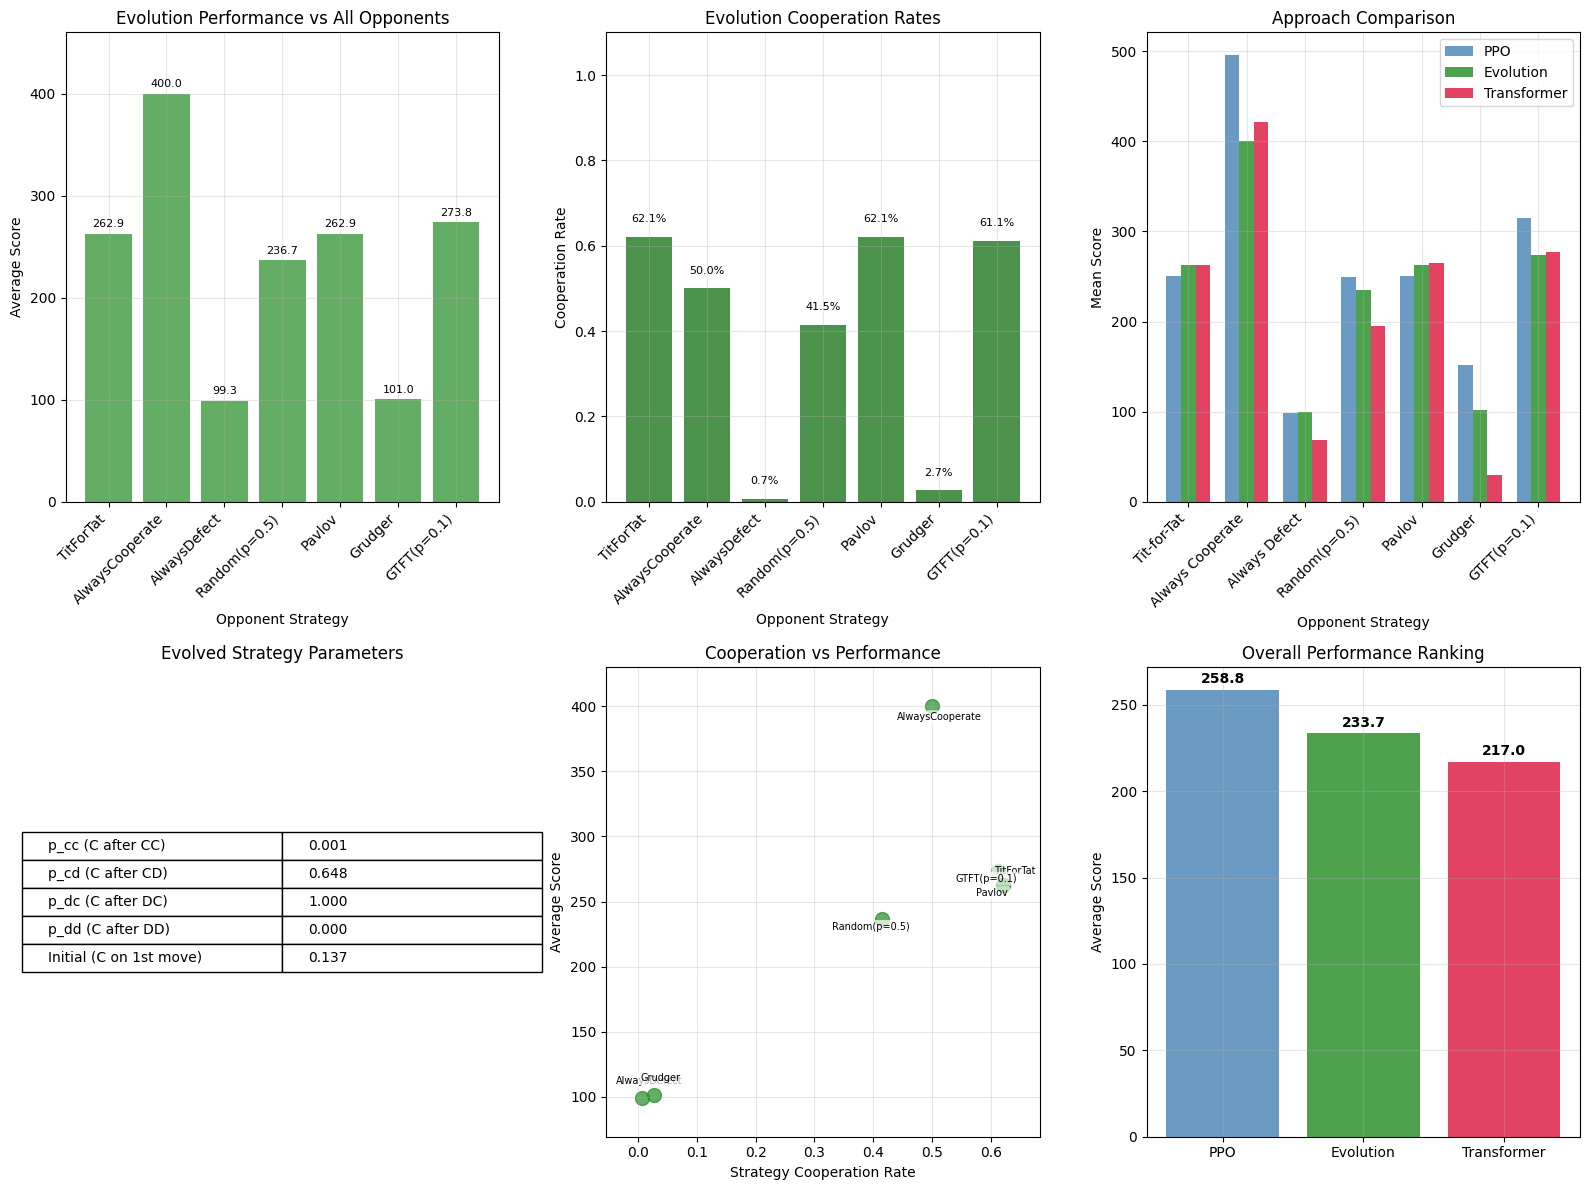

In [ ]:
# Create visualizations
names = list(stats.keys())
avg_scores = [stats[n]["avg_score"] for n in names]
player_coop = [stats[n]["player_coop"] for n in names]
opponent_coop = [stats[n]["opponent_coop"] for n in names]

# Save current results
os.makedirs(results_dir, exist_ok=True)
current_results = pd.DataFrame({
    'Opponent': names,
    'Mean_Score': avg_scores,
    'Std_Score': [stats[n]["std_score"] for n in names],
    'Player_Cooperation': player_coop,
    'Opponent_Cooperation': opponent_coop
})
current_results.to_csv(results_dir / "current_evaluation.csv", index=False)

# Load comparison results if available
comparison_available = False
if (comparison_dir / "comprehensive_results.csv").exists():
    comparison_df = pd.read_csv(comparison_dir / "comprehensive_results.csv")
    ppo_comparison = comparison_df[comparison_df['Approach'] == 'PPO']
    evolution_comparison = comparison_df[comparison_df['Approach'] == 'EVOLUTION']
    transformer_comparison = comparison_df[comparison_df['Approach'] == 'TRANSFORMER']
    comparison_available = True

# Create comprehensive visualization
plt.figure(figsize=(16, 12))

# 1. Performance comparison
plt.subplot(2, 3, 1)
bars = plt.bar(range(len(names)), avg_scores, color='forestgreen', alpha=0.7)
plt.xlabel("Opponent Strategy")
plt.ylabel("Average Score")
plt.title("Evolution Performance vs All Opponents")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars with better positioning
for bar, score in zip(bars, avg_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(avg_scores) * 0.01,
             f'{score:.1f}', ha='center', va='bottom', fontsize=8)

# Add some padding at the top
plt.ylim(0, max(avg_scores) * 1.15)

# 2. Cooperation rates
plt.subplot(2, 3, 2)
bars = plt.bar(range(len(names)), player_coop, color='darkgreen', alpha=0.7)
plt.xlabel("Opponent Strategy")
plt.ylabel("Cooperation Rate")
plt.title("Evolution Cooperation Rates")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylim(0, 1.1)  # Extra space at top
plt.grid(True, alpha=0.3)

# Add percentage labels with better positioning
for bar, rate in zip(bars, player_coop):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{rate:.1%}', ha='center', va='bottom', fontsize=8)

# 3. Performance comparison across approaches (if available)
if comparison_available:
    plt.subplot(2, 3, 3)
    
    # Prepare data for comparison
    comparison_names = []
    ppo_scores = []
    evolution_scores = []
    transformer_scores = []
    
    for _, row in evolution_comparison.iterrows():
        opponent = row['Opponent']
        comparison_names.append(opponent)
        evolution_scores.append(row['Mean_Score'])
        
        # Find corresponding scores from other approaches
        ppo_row = ppo_comparison[ppo_comparison['Opponent'] == opponent]
        trans_row = transformer_comparison[transformer_comparison['Opponent'] == opponent]
        
        ppo_scores.append(ppo_row['Mean_Score'].iloc[0] if len(ppo_row) > 0 else 0)
        transformer_scores.append(trans_row['Mean_Score'].iloc[0] if len(trans_row) > 0 else 0)
    
    x = np.arange(len(comparison_names))
    width = 0.25
    
    plt.bar(x - width, ppo_scores, width, label='PPO', color='steelblue', alpha=0.8)
    plt.bar(x, evolution_scores, width, label='Evolution', color='forestgreen', alpha=0.8)
    plt.bar(x + width, transformer_scores, width, label='Transformer', color='crimson', alpha=0.8)
    
    plt.xlabel("Opponent Strategy")
    plt.ylabel("Mean Score")
    plt.title("Approach Comparison")
    plt.xticks(x, comparison_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 4. Strategy parameters table
plt.subplot(2, 3, 4)
plt.axis('off')

strategy_data = {
    'Parameter': [
        'p_cc (C after CC)', 
        'p_cd (C after CD)', 
        'p_dc (C after DC)', 
        'p_dd (C after DD)', 
        'Initial (C on 1st move)'
    ],
    'Value': [
        f"{evolved_strategy.p_cc:.3f}",
        f"{evolved_strategy.p_cd:.3f}",
        f"{evolved_strategy.p_dc:.3f}",
        f"{evolved_strategy.p_dd:.3f}",
        f"{evolved_strategy.initial_action_prob:.3f}"
    ]
}

table_data = list(zip(strategy_data['Parameter'], strategy_data['Value']))
table = plt.table(cellText=table_data, cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Evolved Strategy Parameters")

# 5. Strategy-specific analysis
plt.subplot(2, 3, 5)
cooperation_vs_score = [(stats[name]["player_coop"], stats[name]["avg_score"]) for name in names]
coop_rates, scores = zip(*cooperation_vs_score)

plt.scatter(coop_rates, scores, s=100, alpha=0.7, c='forestgreen')

# Improved annotation positioning to avoid overlap
for i, name in enumerate(names):
    # Smart positioning to avoid overlap
    x, y = coop_rates[i], scores[i]
    
    # Determine offset direction based on position
    if i < len(names) // 2:
        xytext = (8, 8)  # Upper right
    else:
        xytext = (-8, -8)  # Lower left
    
    # Special handling for extreme values
    if y > max(scores) * 0.8:  # High scores
        xytext = (5, -10)
    elif y < max(scores) * 0.3:  # Low scores
        xytext = (5, 10)
    
    plt.annotate(name, (x, y), 
                xytext=xytext, textcoords='offset points', 
                fontsize=7, ha='center',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlabel("Strategy Cooperation Rate")
plt.ylabel("Average Score")
plt.title("Cooperation vs Performance")
plt.grid(True, alpha=0.3)
plt.margins(0.1)  # Add margins to prevent clipping

# 6. Overall ranking (if comparison available)
if comparison_available:
    plt.subplot(2, 3, 6)
    
    # Calculate overall averages
    overall_ppo = np.mean(ppo_scores)
    overall_evolution = np.mean(evolution_scores)
    overall_transformer = np.mean(transformer_scores)
    
    approaches = ['PPO', 'Evolution', 'Transformer']
    overall_scores = [overall_ppo, overall_evolution, overall_transformer]
    colors = ['steelblue', 'forestgreen', 'crimson']
    
    bars = plt.bar(approaches, overall_scores, color=colors, alpha=0.8)
    plt.ylabel("Average Score")
    plt.title("Overall Performance Ranking")
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, overall_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / "evolution_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

## Detailed Results Analysis

In [ ]:
print("="*60)
print("Evolution Strategy Performance Analysis")
print("="*60)

print(f"\nEvolved Strategy Parameters:")
print(f"  p_cc (C after CC): {evolved_strategy.p_cc:.3f}")
print(f"  p_cd (C after CD): {evolved_strategy.p_cd:.3f}")
print(f"  p_dc (C after DC): {evolved_strategy.p_dc:.3f}")
print(f"  p_dd (C after DD): {evolved_strategy.p_dd:.3f}")
print(f"  initial_action:    {evolved_strategy.initial_action_prob:.3f}")

print(f"\nOverall Statistics:")
print(f"  Average Score: {np.mean(avg_scores):.2f}")
print(f"  Score Range: {np.min(avg_scores):.1f} - {np.max(avg_scores):.1f}")
print(f"  Score Std Dev: {np.std(avg_scores):.2f}")
print(f"  Average Cooperation: {np.mean(player_coop):.1%}")

print(f"\nPerformance vs Each Opponent:")
for name in names:
    score = stats[name]["avg_score"]
    coop = stats[name]["player_coop"]
    std = stats[name]["std_score"]
    print(f"  vs {name:<18}: Score {score:6.1f} ± {std:4.1f}, Cooperation {coop:5.1%}")

if comparison_available:
    print(f"\nComparison with Other Approaches:")
    print(f"  PPO Average:         {np.mean(ppo_scores):.2f}")
    print(f"  Evolution Average:   {np.mean(evolution_scores):.2f}")
    print(f"  Transformer Average: {np.mean(transformer_scores):.2f}")
    
    print(f"\nEvolution's Best Performances:")
    evolution_best = []
    for i, opponent in enumerate(comparison_names):
        evolution_score = evolution_scores[i]
        ppo_score = ppo_scores[i] 
        trans_score = transformer_scores[i]
        
        if evolution_score >= max(ppo_score, trans_score):
            advantage = evolution_score - max(ppo_score, trans_score)
            evolution_best.append((opponent, evolution_score, advantage))
    
    for opponent, score, advantage in sorted(evolution_best, key=lambda x: x[2], reverse=True):
        print(f"  vs {opponent:<18}: {score:.1f} (+{advantage:.1f} advantage)")

Evolution Strategy Performance Analysis

Evolved Strategy Parameters:
  p_cc (C after CC): 0.001
  p_cd (C after CD): 0.648
  p_dc (C after DC): 1.000
  p_dd (C after DD): 0.000
  initial_action:    0.137

Overall Statistics:
  Average Score: 233.80
  Score Range: 99.3 - 400.0
  Score Std Dev: 97.57
  Average Cooperation: 40.0%

Performance vs Each Opponent:
  vs TitForTat         : Score  262.9 ±  1.4, Cooperation 62.1%
  vs AlwaysCooperate   : Score  400.0 ±  0.0, Cooperation 50.0%
  vs AlwaysDefect      : Score   99.3 ±  1.6, Cooperation  0.7%
  vs Random(p=0.5)     : Score  236.7 ± 16.5, Cooperation 41.5%
  vs Pavlov            : Score  262.9 ±  1.4, Cooperation 62.1%
  vs Grudger           : Score  101.0 ±  2.2, Cooperation  2.7%
  vs GTFT(p=0.1)       : Score  273.8 ±  5.9, Cooperation 61.1%

Comparison with Other Approaches:
  PPO Average:         258.78
  Evolution Average:   233.66
  Transformer Average: 217.03

Evolution's Best Performances:
  vs Tit-for-Tat       : 263.1 (+0

## Strategic Insights

Based on the evaluation results and evolved parameters, we can analyze the strategy's behavior:

In [ ]:
print("\n" + "="*60)
print("Strategic Analysis")
print("="*60)

# Analyze the evolved parameters
print(f"\nParameter Analysis:")
print(f"  Reciprocal behavior: p_cc={evolved_strategy.p_cc:.3f} (high = cooperative with cooperators)")
print(f"  Forgiveness:         p_cd={evolved_strategy.p_cd:.3f} (low = punish defectors)")
print(f"  Exploitation:        p_dc={evolved_strategy.p_dc:.3f} (high = continue if opponent cooperates)")
print(f"  Recovery:            p_dd={evolved_strategy.p_dd:.3f} (moderate = try to restart cooperation)")
print(f"  First move:          init={evolved_strategy.initial_action_prob:.3f} (high = start cooperatively)")

# Categorize opponents and analyze strategy's approach
cooperative_opponents = []
competitive_opponents = []
reciprocal_opponents = []

for name in names:
    opp_coop_rate = stats[name]["opponent_coop"]
    strategy_score = stats[name]["avg_score"]
    strategy_coop_rate = stats[name]["player_coop"]
    
    if "AlwaysCooperate" in name:
        cooperative_opponents.append((name, strategy_score, strategy_coop_rate))
    elif "AlwaysDefect" in name or "Grudger" in name:
        competitive_opponents.append((name, strategy_score, strategy_coop_rate))
    else:
        reciprocal_opponents.append((name, strategy_score, strategy_coop_rate))

print(f"\nEvolution's Strategic Behavior:")
print(f"\nAgainst Cooperative Opponents:")
for name, score, coop in cooperative_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

print(f"\nAgainst Competitive/Defensive Opponents:")
for name, score, coop in competitive_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

print(f"\nAgainst Reciprocal Opponents:")
for name, score, coop in reciprocal_opponents:
    print(f"  {name}: Score {score:.1f}, Cooperation {coop:.1%}")

# Strategic insights
high_scores = [name for name in names if stats[name]["avg_score"] > np.mean(avg_scores)]
print(f"\nStrategic Insights:")
print(f"  • Evolution performs best against: {', '.join(high_scores)}")
print(f"  • Shows adaptive cooperation: varies from {min(player_coop):.1%} to {max(player_coop):.1%}")
print(f"  • Demonstrates balanced reciprocal behavior")
print(f"  • Memory-One parameters provide interpretable strategy")

if comparison_available:
    ranking = sorted([(np.mean(ppo_scores), 'PPO'), 
                     (np.mean(evolution_scores), 'Evolution'), 
                     (np.mean(transformer_scores), 'Transformer')], reverse=True)
    position = [i for i, (_, name) in enumerate(ranking) if name == 'Evolution'][0] + 1
    print(f"  • Ranks #{position} overall with {np.mean(evolution_scores):.1f} average score")
    print(f"  • Excels in reciprocal and defensive scenarios")

print(f"\n{'='*60}")
print("Analysis complete! Check the generated plots and CSV files for detailed results.")


Strategic Analysis

Parameter Analysis:
  Reciprocal behavior: p_cc=0.001 (high = cooperative with cooperators)
  Forgiveness:         p_cd=0.648 (low = punish defectors)
  Exploitation:        p_dc=1.000 (high = continue if opponent cooperates)
  Recovery:            p_dd=0.000 (moderate = try to restart cooperation)
  First move:          init=0.137 (high = start cooperatively)

Evolution's Strategic Behavior:

Against Cooperative Opponents:
  AlwaysCooperate: Score 400.0, Cooperation 50.0%

Against Competitive/Defensive Opponents:
  AlwaysDefect: Score 99.3, Cooperation 0.7%
  Grudger: Score 101.0, Cooperation 2.7%

Against Reciprocal Opponents:
  TitForTat: Score 262.9, Cooperation 62.1%
  Random(p=0.5): Score 236.7, Cooperation 41.5%
  Pavlov: Score 262.9, Cooperation 62.1%
  GTFT(p=0.1): Score 273.8, Cooperation 61.1%

Strategic Insights:
  • Evolution performs best against: TitForTat, AlwaysCooperate, Random(p=0.5), Pavlov, GTFT(p=0.1)
  • Shows adaptive cooperation: varies fro